### Objectives
- Build pipelines for preprocessing
- Get a kaggle score better than 0.13
- Test performance of model inference

## Introduction

As a follow up from the previous prediction for Ames datasets, this time around we are going to create a dataset, we will be pedicting prices with ames dataset and will be performing EDA on the same dataset but this time around using boosting techniques and data analysis to improve prediction and using pipelines to ensure that our code is neat and easily used.

In [1]:
conda create -n tensorflow python=3.8 -y

Solving environment: done

## Package Plan ##

  environment location: /Users/lindaoranya/opt/anaconda3/envs/tensorflow

  added / updated specs:
    - python=3.8


The following NEW packages will be INSTALLED:

  ca-certificates    pkgs/main/osx-64::ca-certificates-2021.7.5-hecd8cb5_1
  certifi            pkgs/main/osx-64::certifi-2021.5.30-py38hecd8cb5_0
  libcxx             pkgs/main/osx-64::libcxx-12.0.0-h2f01273_0
  libffi             pkgs/main/osx-64::libffi-3.3-hb1e8313_2
  ncurses            pkgs/main/osx-64::ncurses-6.2-h0a44026_1
  openssl            pkgs/main/osx-64::openssl-1.1.1l-h9ed2024_0
  pip                pkgs/main/osx-64::pip-21.0.1-py38hecd8cb5_0
  python             pkgs/main/osx-64::python-3.8.11-h88f2d9e_1
  readline           pkgs/main/osx-64::readline-8.1-h9ed2024_0
  setuptools         pkgs/main/osx-64::setuptools-52.0.0-py38hecd8cb5_0
  sqlite             pkgs/main/osx-64::sqlite-3.36.0-hce871da_0
  tk                 pkgs/main/osx-64::tk-8.6.10-hb0a8c7a_0
 

In [2]:
conda activate tensorflow


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



Note: you may need to restart the kernel to use updated packages.


In [3]:
#import libraries
from operator import itemgetter    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from scipy.stats import skew
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import  GradientBoostingRegressor
from xgboost import XGBRegressor


print("Modules imported \n")

get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

Modules imported 



In [4]:
# Load raw data
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv') 

In [5]:
set(test.columns)- set(train.columns)

set()

No difference in train and test columns

## EDA

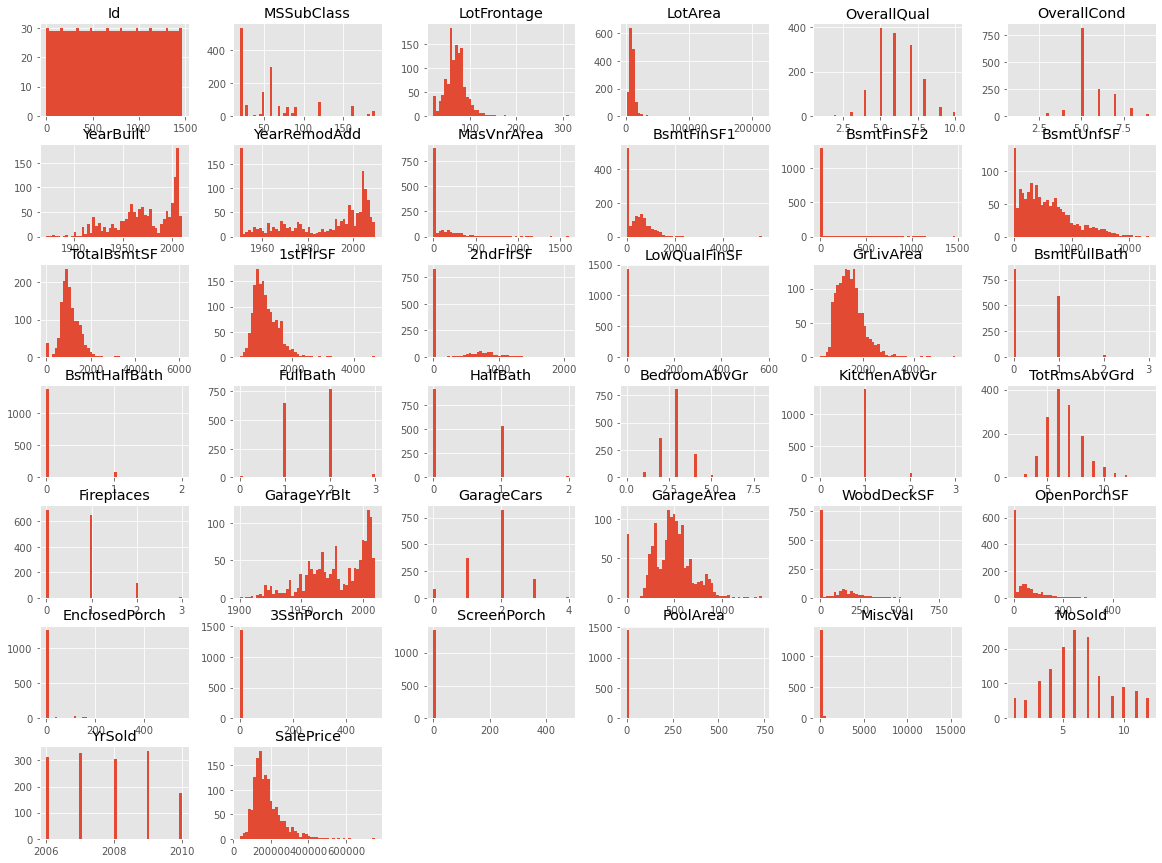

In [6]:
# Histograms
train.hist(bins=50, figsize=(20,15))
plt.show()

- Lotfrontage, LotArea,BsmtFullBath, 1stFloorSF, GrLiveArea and SalePrice are positively skewed.
- TotalBsmtSF,GarageYrBlt are negatively skewed.

- The earliest year sold of a house is 2006 and the latest year sold is 2010.
- The cheapest house sold at 34900 and the most expensive is 755000.
- The latest hosue was also built in 2010

In [7]:
# Pearson Correlation Coefficient
corr_matrix = train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Using Pearson, we can see variables with close positive and negative relationship to the target variables.

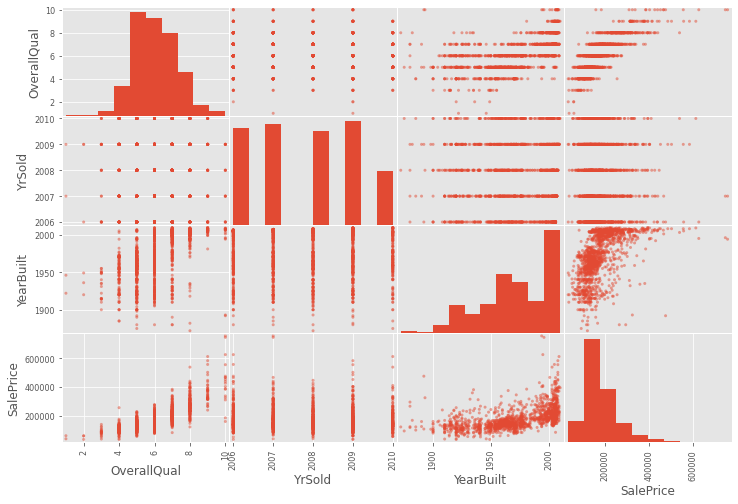

In [8]:
# Scatter_matrix
attributes = ["OverallQual", "YrSold", "YearBuilt","SalePrice"]
scatter_matrix(train[attributes], figsize=(12, 8));

- We can see that there is a relationship between the SalePrice and the Overall Quality of the house.
- Year built and the Sale Price are also correlated.

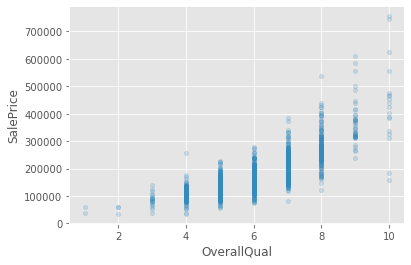

In [9]:
# Zoom in on one plot
train.plot(kind="scatter", x="OverallQual", y="SalePrice",alpha=0.2);

Since there is a positive relationship between the Overall Quality and the SalePrice, the above plot shos that the two varible grow together.

In [10]:
trainWprice = pd.DataFrame(train)
trainNoPrice = trainWprice.drop("SalePrice", axis=1)

trainNoPrice.drop(['Id'],axis=1, inplace=True)
test.drop(['Id'],axis=1, inplace=True)

print("train ", trainNoPrice.shape)
print("test ", test.shape)

train  (1460, 79)
test  (1459, 79)


In [11]:
def check_missing_cols(df) -> pd.DataFrame:
    """
    Checks missing values in a df
    """
    ColsMissingValues = df.isnull().sum()
    print("There are ", len(ColsMissingValues[ColsMissingValues>0]), " features with missing values")

    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    print(missing_data.head(len(ColsMissingValues[ColsMissingValues>0])))

In [12]:
check_missing_cols(train)

There are  19  features with missing values
              Missing Ratio
PoolQC            99.520548
MiscFeature       96.301370
Alley             93.767123
Fence             80.753425
FireplaceQu       47.260274
LotFrontage       17.739726
GarageCond         5.547945
GarageType         5.547945
GarageYrBlt        5.547945
GarageFinish       5.547945
GarageQual         5.547945
BsmtExposure       2.602740
BsmtFinType2       2.602740
BsmtFinType1       2.534247
BsmtCond           2.534247
BsmtQual           2.534247
MasVnrArea         0.547945
MasVnrType         0.547945
Electrical         0.068493


In [13]:
check_missing_cols(test)

There are  33  features with missing values
              Missing Ratio
PoolQC            99.794380
MiscFeature       96.504455
Alley             92.666210
Fence             80.123372
FireplaceQu       50.034270
LotFrontage       15.558602
GarageCond         5.346127
GarageFinish       5.346127
GarageYrBlt        5.346127
GarageQual         5.346127
GarageType         5.209047
BsmtCond           3.084304
BsmtExposure       3.015764
BsmtQual           3.015764
BsmtFinType1       2.878684
BsmtFinType2       2.878684
MasVnrType         1.096642
MasVnrArea         1.028101
MSZoning           0.274160
BsmtHalfBath       0.137080
Utilities          0.137080
Functional         0.137080
BsmtFullBath       0.137080
BsmtFinSF2         0.068540
BsmtFinSF1         0.068540
BsmtUnfSF          0.068540
TotalBsmtSF        0.068540
Exterior2nd        0.068540
SaleType           0.068540
Exterior1st        0.068540
KitchenQual        0.068540
GarageArea         0.068540
GarageCars         0.068540


### Feature Engineering

Manually, grouped the variables into objects and numerical varibles, to help me understand the columns better and also avoid errors that might come up as a result of a varible seen as a numerical because it was encoded 

In [14]:
categorical_features = ["MSZoning","Street","Alley","LotShape","LandContour","Utilities","LotConfig","LandSlope",
                        "Neighborhood","Condition1","Condition2","BldgType","HouseStyle",
                        "RoofStyle","RoofMatl","Exterior1st","Exterior2nd","MasVnrType","ExterQual","ExterCond",
                        "Foundation","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","Heating",
                        "HeatingQC","CentralAir","Electrical","KitchenQual","Functional", "FireplaceQu","GarageType",
                        "GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC", "Fence",
                        "MiscFeature","SaleType","SaleCondition"]
            
                        
numerical_features = ["LotFrontage","LotArea","OverallQual","OverallCond","MasVnrArea","BsmtFinSF1","BsmtFinSF2",
                     "BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
                      "BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr","KitchenAbvGr",
                      "TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF",
                      "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","MoSold","YearBuilt",
                      "YearRemodAdd","GarageYrBlt","YrSold"]

In [15]:
class AddFeature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X) -> pd.DataFrame:
        """
        Transforms dataframe by adding new features
        """
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

        return X

In [16]:
def grid_get(self,X,y,param_grid) -> np.array:
    """
    Performs grid search
    """
    grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(X,y)
    print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
    grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
    print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [17]:
class DropCols(BaseEstimator, TransformerMixin):
    def __init__(self, remove_cols = True):
        self.remove_cols = remove_cols
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X) -> pd.DataFrame:
        """
        Deletes unwanted columns
        """
        if self.remove_cols:
            X.drop(columns=['PoolQC','BsmtFinType1','LowQualFinSF','MoSold','Electrical','BldgType','SaleType',
                           'BsmtFinSF2','Exterior2nd','ExterCond','2ndFlrSF','3SsnPorch','Exterior1st','MasVnrType',
                           'GarageFinish','Alley','PoolArea','RoofStyle','MiscFeature','Fence','BsmtHalfBath',
                            'Street','LotConfig','TotalBsmtSF','GarageYrBlt'])
          
        return X

### Pipeline

In [124]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='median')),
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value="None")),
                    ('encode', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
         sparse_threshold=0.0,)


In [130]:
data_processor = Pipeline(             
                     steps=[('add_feature', AddFeature()),
                     ('drop_cols',DropCols()),
                     ('pre_processing',preprocessor)])

In [131]:
data_processor.fit(trainNoPrice)

Pipeline(steps=[('add_feature', AddFeature()), ('drop_cols', DropCols()),
                ('pre_processing',
                 ColumnTransformer(remainder='passthrough',
                                   sparse_threshold=0.0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF...
                                                   'Alley', 'LotShape',


In [132]:
traindf = data_processor.transform(trainNoPrice)

In [134]:
traindf = pd.DataFrame(traindf)

In [136]:
testdf = data_processor.transform(test)

In [137]:
testdf = pd.DataFrame(testdf)

In [138]:
testdf.shape

(1459, 305)

### Model

### Lasso - Baseline Model

In [67]:
def rmse(y, y_pred) -> float:
    """
    Calculates rmse
    """
    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_cv(model,X,y) -> np.array:
    """
    Function for cross validation
    """
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [68]:
n_train=train.shape[0]
y= train.SalePrice
yFinal = np.log(train.SalePrice)

In [69]:
xtrain, xval, ytrain, yval = train_test_split(traindf, yFinal, test_size=0.2,
                                                    random_state=0)

In [70]:
lasso = Lasso(alpha=0.0005, random_state=1)

In [71]:
lasso.fit(xtrain,ytrain)

Lasso(alpha=0.0005, random_state=1)

In [72]:
%time
lasso_ypred = lasso.predict(xval)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [74]:
lasso_rmse = rmse(yval,lasso_ypred)

In [75]:
lasso_rmse

0.20867388797572506

### GBR

In [76]:
gbr = (GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                                     learning_rate=0.05,max_depth=5,max_features='sqrt',min_impurity_decrease=0.0,
                                     min_samples_leaf=10, min_samples_split=10,n_estimators=500,
                                     presort='auto', random_state=None))
gbr.fit(xtrain,ytrain)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, max_features='sqrt',
                          min_samples_leaf=10, min_samples_split=10,
                          n_estimators=500, presort='auto')

In [77]:
%time
gbr_ypred = gbr.predict(xval)
gbr_rmse = rmse(yval,gbr_ypred)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [78]:
gbr_rmse

0.13043312889589034

### Xtreme boost

In [163]:
XGR=XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                        learning_rate=0.05, max_depth=3, 
                        min_child_weight=1.7817, n_estimators=1500,
                        reg_alpha=0.4640, reg_lambda=0.8571,
                        subsample=0.5213,
                        random_state =7, nthread = -1)

XGR.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, subsample=0.5213, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [164]:
%time
xgr_ypred = XGR.predict(xval)
xgb_rmse = rmse(yval,xgr_ypred)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [165]:
xgb_rmse

0.12955839531562668

### Neural Network

In [82]:
def get_model():
    """
    Define neural network model
    """
    model = Sequential([
        Dense(10, input_shape = xtrain.shape, activation = 'relu'), #10 neurons, Input Layer
        Dense(20, activation = 'relu'),                     #20 neurons, Hidden Layer
        Dense(5, activation = 'relu'),                      #5  neurons, Hidden Layer
        Dense(1)                                            #Output Layer
    ])                                                      #'relu' activation

    model.compile(
        loss='mse',                                         #Trained using Mean square error loss (Cost function) 
        optimizer='adam'                                    #Optimizer used is 'adam' (One of the Fastest optimizers)
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1168, 10)          3060      
_________________________________________________________________
dense_1 (Dense)              (None, 1168, 20)          220       
_________________________________________________________________
dense_2 (Dense)              (None, 1168, 5)           105       
_________________________________________________________________
dense_3 (Dense)              (None, 1168, 1)           6         
Total params: 3,391
Trainable params: 3,391
Non-trainable params: 0
_________________________________________________________________


In [83]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5) #Defining early stopping parameter

model = get_model()

preds_on_untrained = model.predict(xval) #Make predictions on the val set before training the parameters

#Finally training the model-->
history = model.fit(
    xtrain, ytrain,
    validation_data = (xval, yval),
    epochs = 100,
    callbacks = [early_stopping]
)


Epoch 1/100
37/37 [==============================] - 1s 13ms/step - loss: 23586.5195 - val_loss: 114.5930
Epoch 2/100
37/37 [==============================] - 0s 4ms/step - loss: 254.1990 - val_loss: 32.5509
Epoch 3/100
37/37 [==============================] - 0s 3ms/step - loss: 135.2042 - val_loss: 20.0783
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 85.1946 - val_loss: 18.9968
Epoch 5/100
37/37 [==============================] - 0s 3ms/step - loss: 56.0198 - val_loss: 17.5964
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 39.1223 - val_loss: 16.0642
Epoch 7/100
37/37 [==============================] - 0s 4ms/step - loss: 27.3585 - val_loss: 15.6726
Epoch 8/100
37/37 [==============================] - 0s 5ms/step - loss: 21.7934 - val_loss: 14.3537
Epoch 9/100
37/37 [==============================] - 0s 3ms/step - loss: 17.9137 - val_loss: 13.7929
Epoch 10/100
37/37 [==============================] - 0s 6ms/step - loss: 15.4890 - 

37/37 [==============================] - 0s 3ms/step - loss: 2.5378 - val_loss: 2.6441
Epoch 70/100
37/37 [==============================] - 0s 4ms/step - loss: 2.5041 - val_loss: 2.5488
Epoch 71/100
37/37 [==============================] - 0s 3ms/step - loss: 2.4108 - val_loss: 2.4670
Epoch 72/100
37/37 [==============================] - 0s 3ms/step - loss: 2.4253 - val_loss: 2.5716
Epoch 73/100
37/37 [==============================] - 0s 3ms/step - loss: 2.3127 - val_loss: 2.4437
Epoch 74/100
37/37 [==============================] - 0s 3ms/step - loss: 2.2630 - val_loss: 2.3727
Epoch 75/100
37/37 [==============================] - 0s 4ms/step - loss: 2.1909 - val_loss: 2.2267
Epoch 76/100
37/37 [==============================] - 0s 5ms/step - loss: 2.1332 - val_loss: 2.2265
Epoch 77/100
37/37 [==============================] - 0s 5ms/step - loss: 2.0911 - val_loss: 2.2011
Epoch 78/100
37/37 [==============================] - 0s 5ms/step - loss: 2.1060 - val_loss: 2.1790
Epoch 79/100


In [84]:
model.fit(xtrain, ytrain)
%time
ypred = model.predict(xval)

37/37 [==============================] - 0s 2ms/step - loss: 1.0752
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [85]:
nn_rmse = rmse(yval,ypred)

In [86]:
nn_rmse

1.1812407945449428

### Submission

In [90]:
testFinal = testdf.copy()

In [166]:
# SUBMISSION
X_test = testFinal.copy()
sub = pd.read_csv("sample_submission.csv")
%time
pred = np.exp(XGR.predict(testFinal))
sub.SalePrice=pred
sub.to_csv("submission8.csv",index=False)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.3 µs


In [167]:
model_ = ['Lasso','Gradient Boost','XGBoost','Neural Network']
scores = [lasso_rmse,gbr_rmse,xgb_rmse,nn_rmse]
run_times = [0.00626,0.0076,0.0093,0.01]

In [168]:
kaggle_scores = [0.130,0.133,0.127,1.13]

In [169]:
pd.DataFrame({'model':model_,
             'score': scores,
             'runtime':run_times,
             'submission_score':kaggle_scores})

,model,score,runtime,submission_score
0,Lasso,0.208674,0.00626,0.130
1,Gradient Boost,0.130433,0.00760,0.133
2,XGBoost,0.129558,0.00930,0.127
3,Neural Network,1.181241,0.01000,1.130


#### Conclusion
After submission and evaluation, the best score on the leaderboard was gotten by XGBoost, which gave a score of **0.127**.

Future improvements
- Feature crossing can be tried to see if the model performs better
- The model can be optimized better to reduce time 
- Iterative process can be done continuosly to improve model
- More features can be generated from base features, such as age of building etc.